### *Tarea M47 - Bryan Alberto Coronado García*
---

#### *Importación de datos de stocks del ejercicio anterior*

In [51]:
# Importación de librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
# ----------------------------------------------------------
# Importación de librerías de estadística y series de tiempo
# ----------------------------------------------------------
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
from scipy.stats import norm
import math
from sklearn.metrics import mean_squared_error
from matplotlib import rcParams
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
# from numpy.random import normal, seed
# ----------------------------------------------------------
os.chdir('C:/Users/thehe/OneDrive/Escritorio/EBAC/Tareas/6. Machine Learning (M41 - M49)/M47 (Series De Tiempo II)')
os.getcwd()

'C:\\Users\\thehe\\OneDrive\\Escritorio\\EBAC\\Tareas\\6. Machine Learning (M41 - M49)\\M47 (Series De Tiempo II)'

In [ ]:
# Para la elaboración de la práctica de este módulo se usará el dataset de Apple
df_apple = pd.read_csv('Analista de datos AAPL_2006-01-01_to_2018-01-01_M30.csv', index_col = 'Date', parse_dates=['Date'])
df_apple.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


---

#### *Generación de modelo de series de tiempo aplicado a los datos importados usando el modelo de Reversión a la Media, y Movimiento Browniano.*

In [3]:
# +++ Movimiento Browniano +++

# Parámetros del Movimiento Browniano
delta = 0.25
dt = 0.1

# Punto de partida
x = 0
x_ini = 0

# Número de pasos 
n = 10

# Generación de puntos de la serie
for k in range(n):
    x = x + norm.rvs(scale=delta ** 2 * dt)
    print(x)
    
# Trayectorias e iteraciones
n_tray = 10
n_iter = 20

0.0008660123564254923
-0.017446841168177414
-0.01225407145780243
-0.015050746272629742
-0.013457738602014341
-0.02237695419310045
-0.023142995358749443
-0.033584314789357674
-0.026008696383796784
-0.01637254719382101


In [15]:
# Dataframe para verificar el camino de la variable en su trayectoria
resid = []
df_res = pd.DataFrame().assign(traj=0, nsample=0, sample=0)

# Inducción de las trayectorias en el DataFrame
for i in range(n_tray+1):
    for k in range(1,n_iter+1):
        x = x + norm.rvs(scale=delta ** 2 * dt)
        resid.append(x)
        df2 = pd.DataFrame([{'traj': i, 'nsample': k, 'sample': x}])
        df_res = pd.concat([df_res, df2], ignore_index=True)
        
df_res.tail(5)

,traj,nsample,sample
215,10,16,-0.023046
216,10,17,-0.019114
217,10,18,-0.025507
218,10,19,-0.028015
219,10,20,-0.027923


Text(0.5, 1.0, 'Trayectorias del Movimiento Browniano')

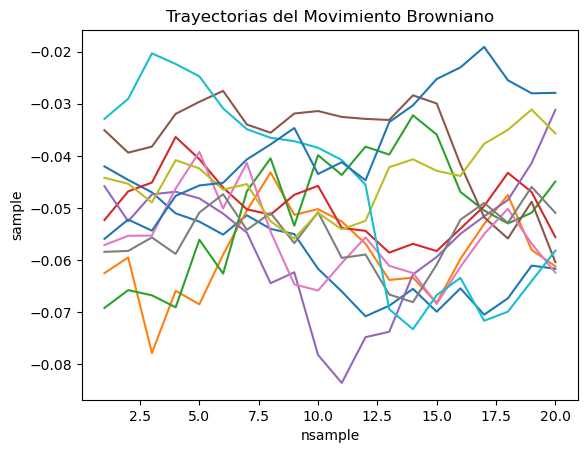

In [19]:
# Plot de las trayectorias
sns.lineplot(x='nsample', y='sample', hue='traj', data=df_res, palette='tab10', legend=None)
plt.title('Trayectorias del Movimiento Browniano')

In [14]:
# Pivot Table para el gráfico de la serie
pd.pivot_table(df_res, index=['traj'], columns=['nsample'])

sample                                                              \
nsample        1         2         3         4         5         6         7    
traj                                                                            
0        0.030160  0.028141  0.020657  0.029165  0.022395  0.026156  0.013876   
1        0.031020  0.020883  0.021877  0.018312  0.016887  0.017578  0.017660   
2        0.053412  0.060334  0.046934  0.048572  0.044656  0.049850  0.055460   
3        0.069159  0.071799  0.056951  0.051399  0.058243  0.057131  0.051864   
4        0.067414  0.063830  0.066937  0.067235  0.068313  0.063985  0.067005   
5        0.012772  0.010921  0.020373  0.017252  0.015783  0.021716  0.011968   
6       -0.005596 -0.009566 -0.019143 -0.024413 -0.017090 -0.023801 -0.029932   
7       -0.048027 -0.050171 -0.041674 -0.037969 -0.038603 -0.030046 -0.038536   
8       -0.046026 -0.052589 -0.052938 -0.048758 -0.048770 -0.051345 -0.054757   
9       -0.053672 -0.061743 -0.049761 -0.048036 -0.037149 -0.042541 -0.041483   
10      -0.060607 -0.057128 -0.054757 -0.045572 -0.028059 -0.030040 -0.029325   

                                                                               \
nsample        8         9         10        11        12        13        14   
traj                                                                            
0        0.017167  0.016565  0.022786  0.019961  0.018811  0.014233  0.022056   
1        0.011268  0.018667  0.026610  0.038156  0.031238  0.036531  0.039841   
2        0.053571  0.047480  0.047562  0.047131  0.046240  0.058065  0.060288   
3        0.048190  0.059155  0.067238  0.064411  0.069861  0.066790  0.072283   
4        0.068905  0.059156  0.052719  0.046740  0.046442  0.044925  0.051341   
5        0.012957  0.005642  0.006386  0.011155  0.016566  0.007850  0.004993   
6       -0.032801 -0.023283 -0.016325 -0.028272 -0.022441 -0.022746 -0.038219   
7       -0.032562 -0.040788 -0.042145 -0.042606 -0.049491 -0.046230 -0.035962   
8       -0.052410 -0.050057 -0.045159 -0.051699 -0.044908 -0.037543 -0.038038   
9       -0.044066 -0.048909 -0.060023 -0.054734 -0.065917 -0.056436 -0.053267   
10      -0.040132 -0.036675 -0.047593 -0.039658 -0.051070 -0.044053 -0.041486   

                                                                     
nsample        15        16        17        18        19        20  
traj                                                                 
0        0.015613  0.019387  0.011393  0.016600  0.018911  0.022531  
1        0.033727  0.037335  0.032263  0.033236  0.038793  0.047330  
2        0.058732  0.055918  0.055328  0.052440  0.055991  0.060451  
3        0.070229  0.070474  0.073377  0.074435  0.067344  0.070450  
4        0.042177  0.038260  0.038629  0.041362  0.038180  0.025991  
5       -0.001248 -0.007565 -0.007209 -0.004402 -0.002989 -0.007503  
6       -0.043392 -0.038387 -0.039657 -0.036105 -0.036991 -0.041104  
7       -0.038175 -0.036620 -0.037319 -0.027033 -0.030566 -0.041544  
8       -0.041816 -0.037590 -0.040624 -0.047281 -0.051017 -0.059061  
9       -0.058790 -0.057143 -0.052382 -0.066979 -0.065575 -0.056579  
10      -0.033336 -0.023876 -0.033936 -0.040091 -0.034759 -0.039318

In [24]:
# +++ Modelo De Reversión a la Media (Vasicek) +++

# VALORES DEL MODELO DE VASICEK:
# Parámetros:
# r0: tasa inicial
# kappa: velocidad de reversión a la media
# theta: nivel de largo plazo
# sigma: volatilidad
# T: tiempo total
# dt: paso de tiempo

def vasicek(r0, kappa, theta, sigma, T=1, N=10, dt=10, seed=df_apple['Close'].mean()):
    dt = T / float(N)
    rates = [r0]
    for i in range(N):
        dr = kappa * (theta - rates[-1]) * dt + sigma * df_apple['Close'].std() * np.sqrt(dt) * norm.rvs()
        rates.append(rates[-1] + dr)
    return range(N + 1), rates

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


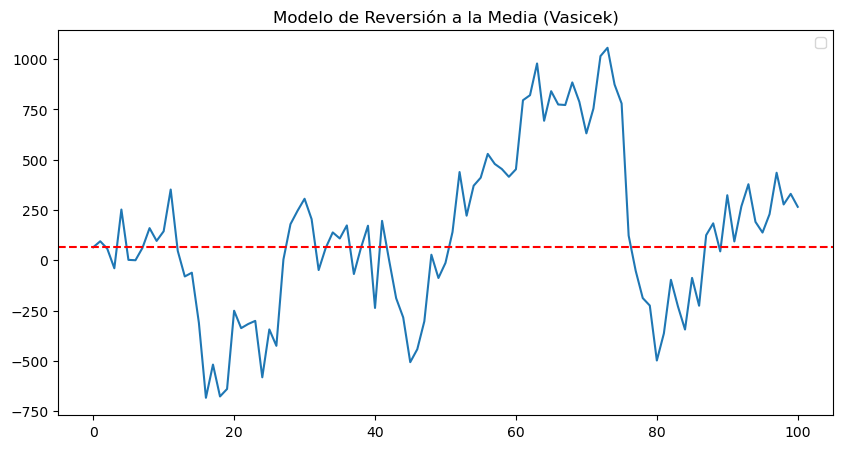

In [32]:
r0 = df_apple['Close'].mean()
kappa = 0.1
theta = df_apple['Close'].mean()
sigma = df_apple['Close'].std()
T = 1
N = 100

x, y = vasicek(r0, kappa, theta, sigma, T, N)

# Plot de la serie
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.title('Modelo de Reversión a la Media (Vasicek)')
plt.axhline(theta, color='red', linestyle='--')
plt.legend()
plt.show()

#### *Modelo autorregresivo y Moving average.*

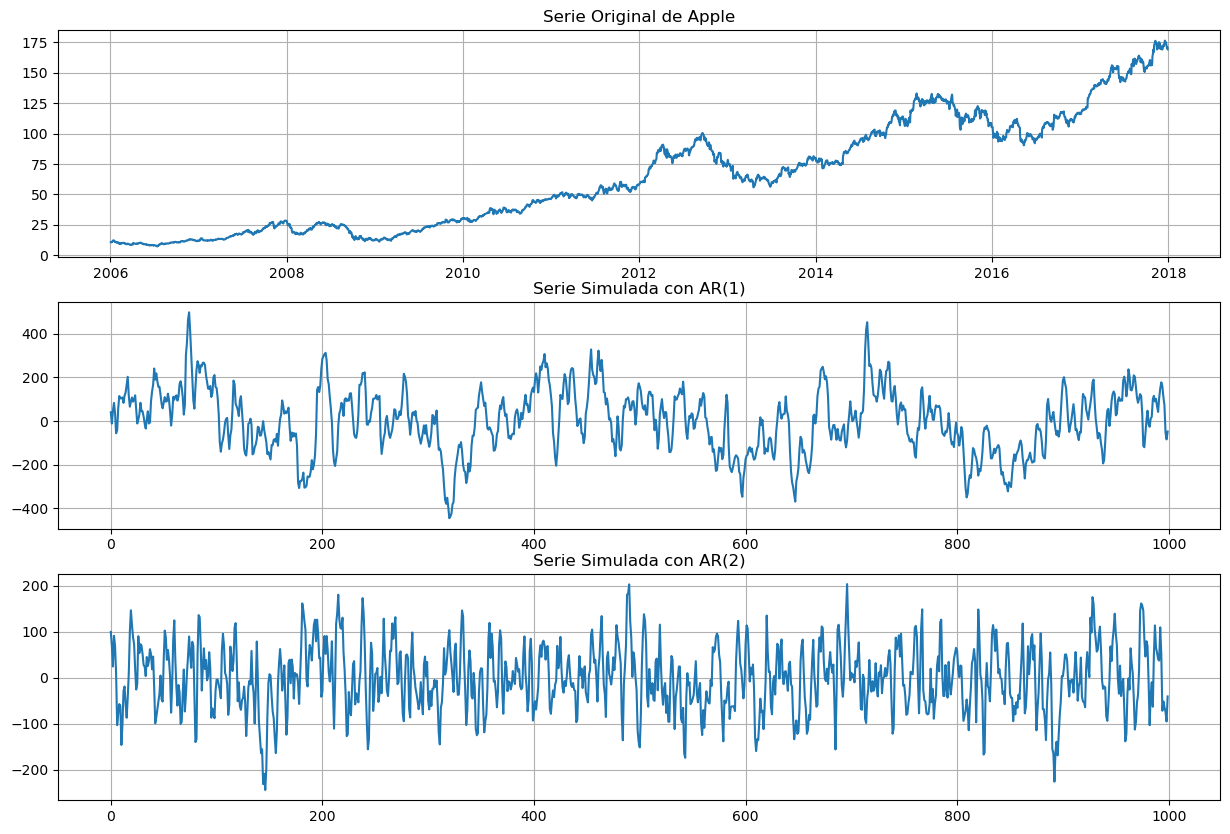

In [ ]:
# +++ Modelo autorregresivo +++

rcParams['figure.figsize'] = 15,10
rcParams['axes.grid'] = True
plt.subplot(3,1,1)

plt.plot(df_apple['Close'], label='Serie Original')
plt.title('Serie Original de Apple')

plt.subplot(3,1,2)
ar1 = np.array([1, -0.9])
ma1 = np.array([1, 0.5])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000, scale=df_apple['Close'].std())
plt.title('Serie Simulada con AR(1)')
plt.plot(sim1, label='Serie Simulada')

plt.subplot(3,1,3)
ar2 = np.array([1, -0.5])
ma2 = np.array([1, 0.5])
AR2 = ArmaProcess(ar2, ma2)
sim2 = AR2.generate_sample(nsample=1000, scale=df_apple['Close'].std())
plt.title('Serie Simulada con AR(2)')
plt.plot(sim2, label='Serie Simulada')


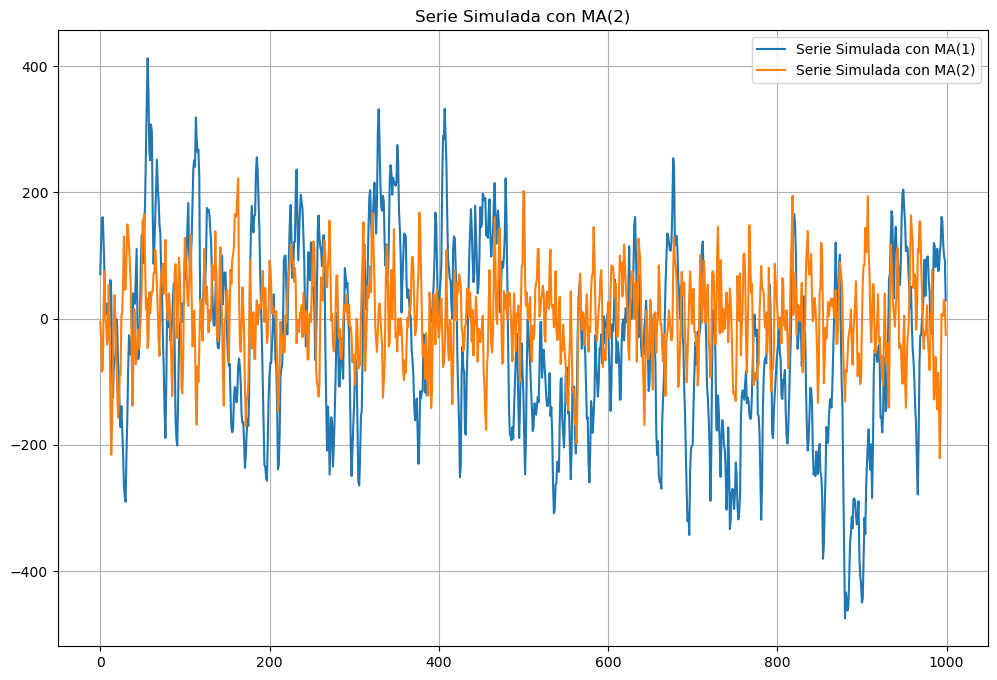

In [65]:
# +++ Moving Average +++

rcParams['figure.figsize'] = 12,8
rcParams['axes.grid'] = True
ar1 = np.array([1, -0.9])
ma1 = np.array([1, 0.5])
MA1 = ArmaProcess(ar1, ma1)
sim1 = MA1.generate_sample(nsample=1000, scale=df_apple['Close'].std())
plt.plot(sim1, label='Serie Simulada con MA(1)')
plt.title('Serie Simulada con MA(1)')
plt.legend()
rcParams['axes.grid'] = True
ar2 = np.array([1, -0.5])
ma2 = np.array([1, 0.5])
MA2 = ArmaProcess(ar2, ma2)
sim2 = MA2.generate_sample(nsample=1000, scale=df_apple['Close'].std())
plt.plot(sim2, label='Serie Simulada con MA(2)')
plt.title('Serie Simulada con MA(2)')
plt.legend()

#### *Ejercicio de predicción de modelos.*

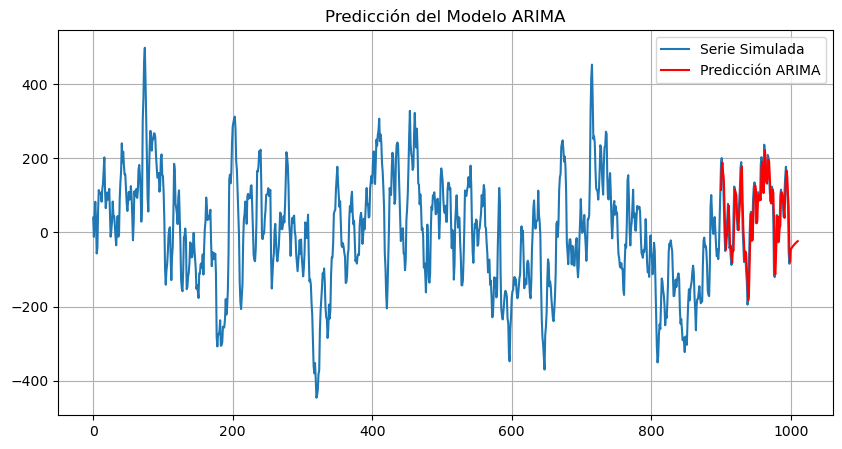

In [57]:
pred = result.predict(start=900, end=1010)
plt.figure(figsize=(10,5))
plt.plot(sim1, label='Serie Simulada')
plt.plot(range(900, 1011), pred, color='red', label='Predicción ARIMA')
plt.title('Predicción del Modelo ARIMA')
plt.legend()
plt.show()

In [58]:
# Evaluación del modelo con RMSE
rmse = math.sqrt(mean_squared_error(sim1[900:1011], result.predict(start=900, end=999)))
print(f'RMSE del modelo ARIMA: {rmse}')

RMSE del modelo ARIMA: 49.24250783733403


#### *Visualización simple de Series de Tiempo.*

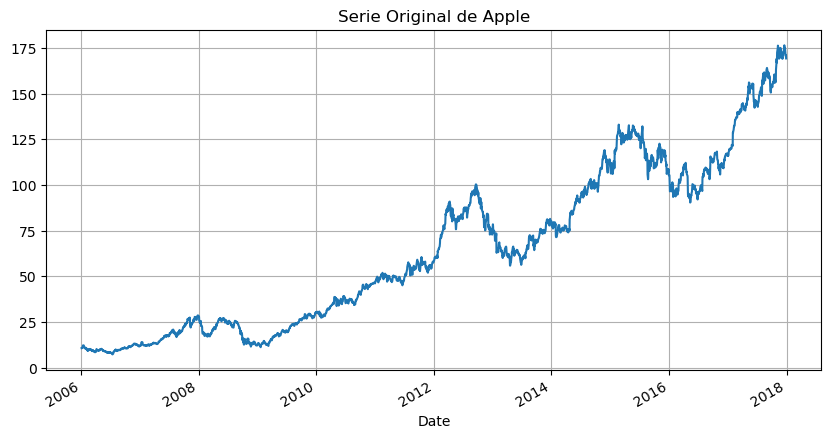

In [68]:
df_apple['Close'].plot(label='Serie Original', figsize=(10, 5))
plt.title('Serie Original de Apple')
plt.show()
